In [ ]:
!pip install tensorflow_addons


In [ ]:
import json, h5py, os, shutil, sys
import numpy as np
import matplotlib.pyplot as plt
from time import time
from PIL import Image

import tensorflow as tf
from tensorflow import saved_model
from tensorflow.keras import backend, applications, optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.framework import ops
import tensorflow_addons as tfa

import math
import os

In [ ]:
def enable_gpu_memory_growth():
    """
    Enables memory groth mode for GPUs.
    """
    gpus = tf.config.experimental.list_physical_devices('GPU')
    assert len(gpus) > 0, "No GPUs detected!"
            
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

enable_gpu_memory_growth()

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("TensorFlow version: " + tf.__version__)

TensorFlow version: 2.2.0


In [ ]:
checkpoint_dir = os.path.join('/content/drive/My Drive/runtime_files', 'saved_model')
checkpoint_auto_dir = os.path.join('/content/drive/My Drive/runtime_files', 'auto_saved_model.h5')
tensorboard_log_dir = os.path.join('/content/drive/My Drive/runtime_files', 'logs', str(time()))

#config = SimilarityConfigParser()

# File paths in ***YOUR GOOGLE DRIVE***

In [ ]:
#file paths
train_folder_path = '/content/drive/My Drive/Kursinis/data'
test_folder_path = '/content/drive/My Drive/Kursinis/data'
model_save_path = '/content/drive/My Drive/Kursinis/Models'

# Importing the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
batch_size = 1
argN = 64

train_folder = train_folder_path
test_folder = test_folder_path

#train_folder = config.get_train_data_folder()
#test_folder = config.get_test_data_folder()

#train_dir_anchor = os.path.join(train_folder, 'train_bw_a')
#train_dir_positive = os.path.join(train_folder, 'train_bw_p')
#train_dir_negative = os.path.join(train_folder, 'train_bw_n')

#valid_dir_anchor = os.path.join(train_folder, 'valid_bw_a')
#valid_dir_positive = os.path.join(train_folder, 'valid_bw_p')
#valid_dir_negative = os.path.join(train_folder, 'valid_bw_n')

#test_dir_anchor = os.path.join(train_folder, 'valid_bw_a')
#test_dir_positive = os.path.join(train_folder, 'valid_bw_p')
#test_dir_negative = os.path.join(train_folder, 'valid_bw_n')


train_dir_anchor = os.path.join(train_folder, 'train_a')
train_dir_positive = os.path.join(train_folder, 'train_p')
train_dir_negative = os.path.join(train_folder, 'train_n')

valid_dir_anchor = os.path.join(train_folder, 'valid_a')
valid_dir_positive = os.path.join(train_folder, 'valid_p')
valid_dir_negative = os.path.join(train_folder, 'valid_n')

test_dir_anchor = os.path.join(test_folder, 'test_a')
test_dir_positive = os.path.join(test_folder, 'test_p')
test_dir_negative = os.path.join(test_folder, 'test_n')

In [ ]:
def train_generator_triplet():
    gen = ImageDataGenerator()
    gen_a = gen.flow_from_directory(directory = train_dir_anchor, target_size = (224, 224), batch_size = batch_size, class_mode = 'categorical', shuffle = False)
    gen_p = gen.flow_from_directory(directory = train_dir_positive, target_size = (224, 224), batch_size = batch_size, class_mode = 'categorical', shuffle = False)
    gen_n = gen.flow_from_directory(directory = train_dir_negative, target_size = (224, 224), batch_size = batch_size, class_mode = 'categorical', shuffle = False)
    while True:
        an = gen_a.next()
        po = gen_p.next()
        ne = gen_n.next()
        yield [an[0], po[0], ne[0]], an[1]

def valid_generator_triplet():
    gen = ImageDataGenerator()
    gen_a = gen.flow_from_directory(directory = valid_dir_anchor, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_p = gen.flow_from_directory(directory = valid_dir_positive, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_n = gen.flow_from_directory(directory = valid_dir_negative, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    while True:
        an = gen_a.next()
        po = gen_p.next()
        ne = gen_n.next()
        yield [an[0], po[0], ne[0]], an[1]

def test_generator_triplet():
    gen = ImageDataGenerator()
    gen_a = gen.flow_from_directory(directory = test_dir_anchor, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_p = gen.flow_from_directory(directory = test_dir_positive, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    gen_n = gen.flow_from_directory(directory = test_dir_negative, target_size = (224, 224), batch_size = 1, class_mode = 'categorical', shuffle = False)
    while True:
        an = gen_a.next()
        po = gen_p.next()
        ne = gen_n.next()
        yield [an[0], po[0], ne[0]], an[1]

# Loss & metric functions

In [ ]:
def triplet_loss(N = argN, epsilon = 1e-6):
    def triplet_loss(y_true, y_pred):
        beta = N
        print("Shape:", y_pred.get_shape())

        anchor = y_pred[0::3]
        positive = y_pred[1::3]
        negative = y_pred[2::3]

        positive_distance = tf.reduce_sum(input_tensor=tf.square(tf.subtract(anchor, positive)), axis = 0, keepdims = True)
        negative_distance = tf.reduce_sum(input_tensor=tf.square(tf.subtract(anchor, negative)), axis = 0, keepdims = True)

        positive_distance = -tf.math.log(-tf.math.divide((positive_distance), beta) + 1 + epsilon)
        negative_distance = -tf.math.log(-tf.math.divide((N - negative_distance), beta) + 1 + epsilon)
        
        #positive_distance = np.nansum(np.square(anchor - positive), axis = 1)
        #positive_distance = - np.log(- (positive_distance / beta) + 1 + epsilon)
        #negative_distance = np.nansum(np.square(anchor - negative), axis = 1)
        #negative_distance = - np.log(- (negative_distance / beta) + 1 + epsilon)
        
        loss = positive_distance + negative_distance
        #loss = tf.math.maximum(positive_distance - negative_distance + 0.5, 0)
        return loss
    return triplet_loss

In [ ]:
def pd(N = argN, epsilon = 1e-6):
    def pd(y_true, y_pred):
        beta = N
        anchor = y_pred[0::3]
        positive = y_pred[1::3]
        positive_distance = tf.reduce_sum(input_tensor=tf.square(tf.subtract(anchor, positive)), axis=0)
        #positive_distance = -tf.math.log(-tf.math.divide((positive_distance), beta) + 1 + epsilon)
        return backend.mean(positive_distance)
    return pd

def nd(N = argN, epsilon = 1e-06):
    def nd(y_true, y_pred):
        beta = N
        anchor = y_pred[0::3]
        negative = y_pred[2::3]
        negative_distance = tf.reduce_sum(input_tensor=tf.square(tf.subtract(anchor, negative)), axis=0)
        #negative_distance = -tf.math.log(-tf.math.divide((N - negative_distance), beta) + 1 + epsilon)
        return backend.mean(negative_distance)
    return nd

# Loading Model

NOTE: Model is already created

In [ ]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [ ]:

with open('/content/drive/My Drive/Kursinis/Models/model.h5') as model_file
model = tf.keras.models.load_model(model_file)

# Show the model architecture
model.summary()

OSError: ignored

# Defining the model

In [ ]:
def make_model():
    input_a = Input(shape = (224, 224, 3),  name = 'input_a')
    input_p = Input(shape = (224, 224, 3),  name = 'input_p')
    input_n = Input(shape = (224, 224, 3),  name = 'input_n')

    base_model = applications.VGG16(include_top = False, weights = 'imagenet')

    l1_a = base_model.layers[0](input_a)
    l1_p = base_model.layers[0](input_p)
    l1_n = base_model.layers[0](input_n)

    l2_a = base_model.layers[1](l1_a)
    l2_p = base_model.layers[1](l1_p)
    l2_n = base_model.layers[1](l1_n)

    l3_a = base_model.layers[2](l2_a)
    l3_p = base_model.layers[2](l2_p)
    l3_n = base_model.layers[2](l2_n)

    l4_a = base_model.layers[3](l3_a)
    l4_p = base_model.layers[3](l3_p)
    l4_n = base_model.layers[3](l3_n)

    l5_a = base_model.layers[4](l4_a)
    l5_p = base_model.layers[4](l4_p)
    l5_n = base_model.layers[4](l4_n)

    l6_a = base_model.layers[5](l5_a)
    l6_p = base_model.layers[5](l5_p)
    l6_n = base_model.layers[5](l5_n)

    l7_a = base_model.layers[6](l6_a)
    l7_p = base_model.layers[6](l6_p)
    l7_n = base_model.layers[6](l6_n)

    l8_a = base_model.layers[7](l7_a)
    l8_p = base_model.layers[7](l7_p)
    l8_n = base_model.layers[7](l7_n)

    l9_a = base_model.layers[8](l8_a)
    l9_p = base_model.layers[8](l8_p)
    l9_n = base_model.layers[8](l8_n)

    lt1 = Dense(64, activation = 'sigmoid')
    lt2 = Dropout(0.5)
    lt3 = Dense(8, activation = 'sigmoid')

    lt1_a = lt1(l9_a)
    lt1_p = lt1(l9_p)
    lt1_n = lt1(l9_n)

    lt2_a = lt2(lt1_a)
    lt2_p = lt2(lt1_p)
    lt2_n = lt2(lt1_n)

    lt3_a = lt3(lt2_a)
    lt3_p = lt3(lt2_p)
    lt3_n = lt3(lt2_n)

    output = tf.keras.layers.concatenate([lt3_a, lt3_p, lt3_n], axis = 0, name = 'out666')
    model = tf.keras.models.Model(inputs = [input_a, input_p, input_n], outputs = output)

    for layer in model.layers:
        if layer.name == 'dense':
            break
        layer.trainable = False

    model.compile(optimizer = optimizers.Adam(), loss = triplet_loss(), metrics = [pd(), nd()])

    return model

# Training

In [ ]:
def plot_metrics(history, metrics=['loss'], skip_start=0.):
    """
    Plots metrics from keras training history.
    """
    hist = history.history
    start_indice = int(len(hist[metrics[0]]) * skip_start)
    
    for metric in metrics:
        plt.plot(hist[metric][start_indice:], label="train {}".format(metric))
        plt.plot(hist[f"val_{metric}"][start_indice:], label=f"val {metric}")
        plt.legend()
        plt.title(metric)
        plt.figure()
    
    plt.show()

Training loop

Setting up the callbacks. Added 2 additional callbacks for training:
  - `EarlyStopping` - stops the model once it's no longer getting better at validation data
  - `ReduceLROnPlateau` - reduces learning rate when model doesn't improve on the validation data for some period

In [ ]:
callbacks = [
#     TensorBoard(log_dir = tensorboard_log_dir, histogram_freq = 2, write_graph = True, write_images = True),
#     ModelCheckpoint(checkpoint_auto_dir, save_weights_only = False, period = 100, verbose = 1),
    EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
]

In [ ]:
!nvidia-smi

Tue May 12 14:21:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
model = make_model()
history = model.fit_generator(
    generator = train_generator_triplet(), 
    steps_per_epoch = 1188, 
    epochs = 1000, 
    validation_data = valid_generator_triplet(), 
    validation_steps = 100, 
    callbacks = callbacks,
    shuffle = False
)

#to save model in case of miss happens
model.save(model_save_path + '/model.h5')

Found 1188 images belonging to 1 classes.
Found 1198 images belonging to 1 classes.
Found 1188 images belonging to 1 classes.
Epoch 1/1000
Shape: (None, 56, 56, 8)
Shape: (None, 56, 56, 8)
1186/1188 [============================>.] - ETA: 0s - loss: 7.8913 - pd: 0.0811 - nd: 0.0834Found 105 images belonging to 1 classes.
Found 105 images belonging to 1 classes.
Found 105 images belonging to 1 classes.
Shape: (None, 56, 56, 8)
1188/1188 [==============================] - 21s 18ms/step - loss: 7.8913 - pd: 0.0811 - nd: 0.0834 - val_loss: 8.9781 - val_pd: 0.0250 - val_nd: 0.0271 - lr: 0.0010
Epoch 2/1000
1188/1188 [==============================] - 21s 17ms/step - loss: 7.8906 - pd: 0.0820 - nd: 0.0835 - val_loss: 8.9790 - val_pd: 0.0251 - val_nd: 0.0271 - lr: 0.0010
Epoch 3/1000
1188/1188 [==============================] - 20s 17ms/step - loss: 7.8908 - pd: 0.0824 - nd: 0.0834 - val_loss: 8.9802 - val_pd: 0.0251 - val_nd: 0.0271 - lr: 0.0010
Epoch 4/1000
1185/1188 [======================

In [ ]:
model.metrics

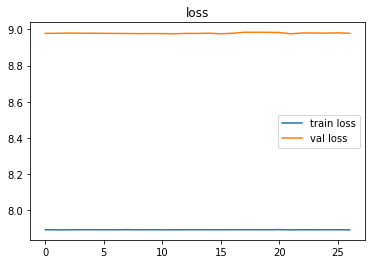

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_metrics(history, metrics=['loss',], skip_start=0.0)


In [ ]:
# Worng path
# model.save('/content/drive/My Drive/runtime_files/model.h5')




```
# This is formatted as code
```

`test_model` function not fixed yet

# Testing 
## After training

In [ ]:
test_samples = len(os.listdir(os.path.join(test_dir_anchor, "0")))
results = model.predict_generator(generator = test_generator_triplet(), steps = test_samples, verbose = 0)

Found 64 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 64 images belonging to 1 classes.


(56, 56, 8)


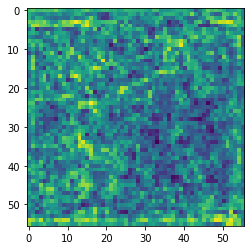

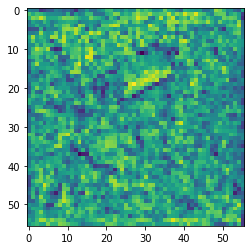

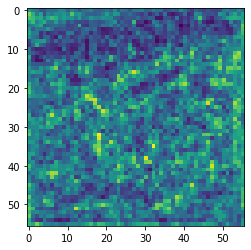

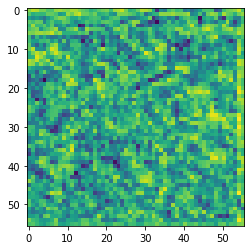

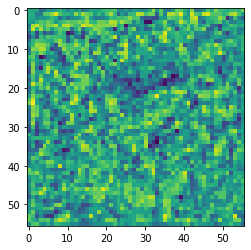

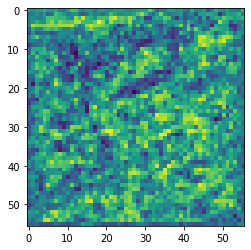

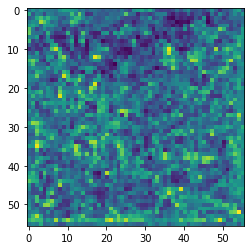

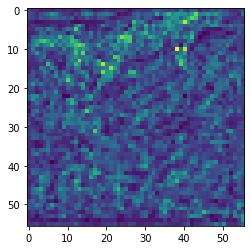

In [ ]:
results_images = results[0,:,:,:]
print(results_images.shape)
for i in range(8):
    plt.imshow(results_images[:,:,i])
    plt.show()

#plt.imshow(results_images)

Showing triplet embedding: 0


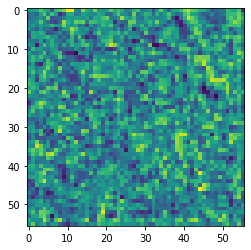

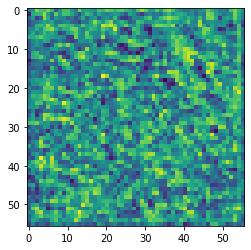

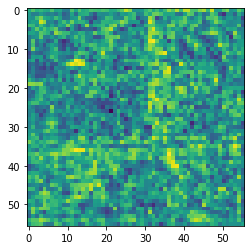

Showing triplet embedding: 1


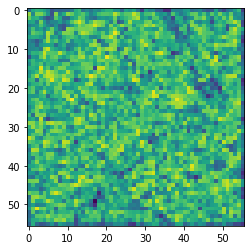

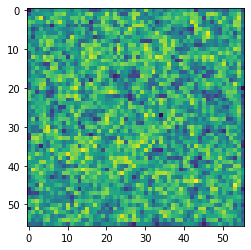

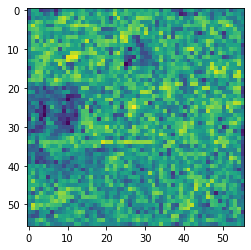

Showing triplet embedding: 2


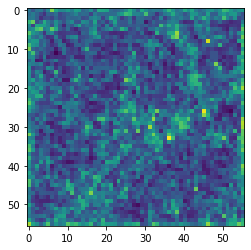

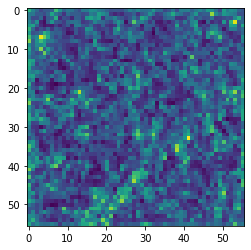

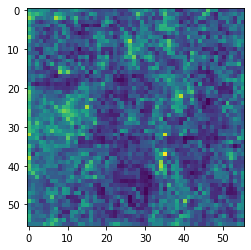

Showing triplet embedding: 3


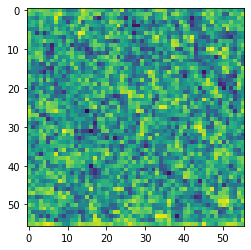

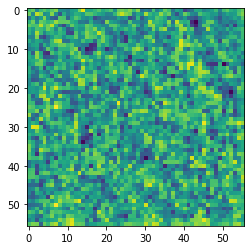

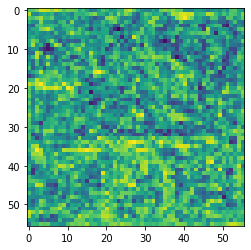

Showing triplet embedding: 4


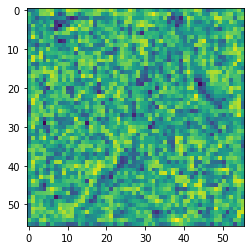

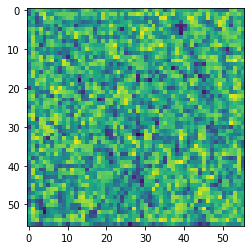

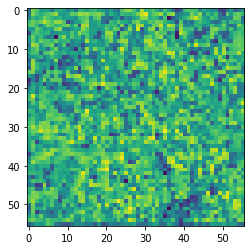

Showing triplet embedding: 5


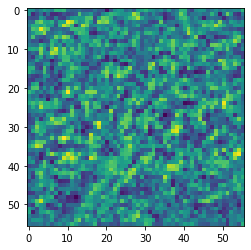

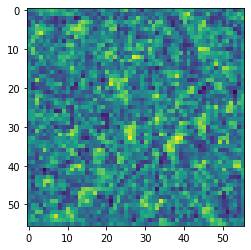

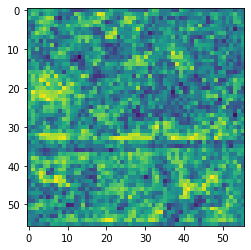

Showing triplet embedding: 6


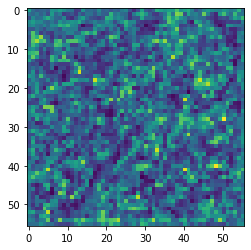

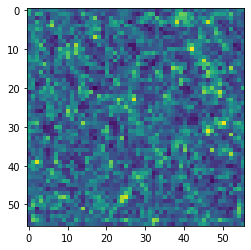

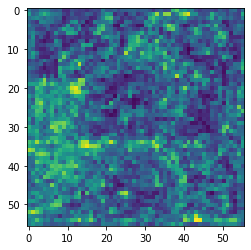

Showing triplet embedding: 7


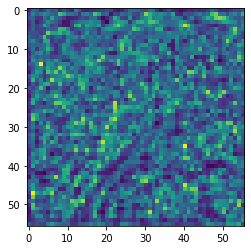

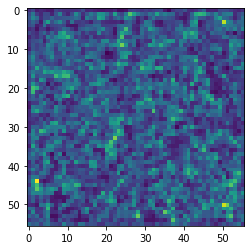

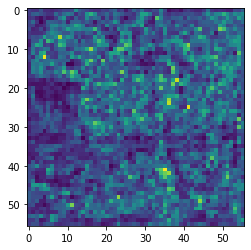

In [ ]:
anchor = results[0::3]
positive = results[1::3]
negative = results[2::3]

def print_results(index, anchor, positive, negative):
    for embedding_index in range(8):
        print("Showing triplet embedding: {}".format(embedding_index))
        plt.imshow(anchor[index,:,:,embedding_index])
        plt.show()
        plt.imshow(positive[index,:,:,embedding_index])
        plt.show()
        plt.imshow(negative[index,:,:,embedding_index])
        plt.show()

print_results(34, anchor, positive, negative)


In [ ]:
beta = argN
epsilon = 1e-6

anchor = results[0::3]
positive = results[1::3]
negative = results[2::3]

print(np.square(anchor - negative).shape)

positive_distance = np.nansum(np.square(anchor - positive), axis = 1)
negative_distance = np.nansum(np.square(anchor - negative), axis = 1)


tp = 0
fp = 0
pneq = 0
min_p = sys.maxsize
max_p = 0
min_n = sys.maxsize
max_n = 0


pd_list = []
nd_list = []

for i in range(test_samples):
    pda = np.nansum(positive_distance[i])
    nda = np.nansum(negative_distance[i])
    
    pd_list.append(pda)
    nd_list.append(nda)

    for pd, nd in zip(pd_list, nd_list):
      # Max diff between 8 images of size 56*56 (network output)
      pda = (pd / 25088)
      nda = (nd / 25088)
      #print("{:.5f}".format((pd / 25088)), "{:.5f}".format((nd / 25088)))
    
    print("Image: {}:".format(i), pda, "\t", nda)
    if pda >= 0.25:
        fp += 1
    else:
        tp += 1
    if pda == nda:
        pneq += 1

    if min_p > pda:
        min_p = pda
    if max_p < pda:
        max_p = pda

    if min_n > nda:
        min_n = nda
    if max_n < nda:
        max_n = nda
        



print(min_p, ' - ', max_p, ', ', min_n, ' - ', max_n)
print('accuracy: ', np.round(tp / (tp + fp) * 100, 1))
print('equal predictions: ', pneq)

(64, 56, 56, 8)
Image: 0: 0.02231450470126405 	 0.024560787239853218
Image: 1: 0.022367375237601145 	 0.025462437649162447
Image: 2: 0.02290271739570462 	 0.027390358399371713
Image: 3: 0.0223250827010797 	 0.025820323399135044
Image: 4: 0.022561798290330535 	 0.02622990218960509
Image: 5: 0.02228161266871861 	 0.02390676615189533
Image: 6: 0.023327350616455078 	 0.0263633241458815
Image: 7: 0.023177589688982283 	 0.02703202014066735
Image: 8: 0.024945624020634865 	 0.027276236183789312
Image: 9: 0.02407097816467285 	 0.026973454319700902
Image: 10: 0.024102016371123646 	 0.027831089739896814
Image: 11: 0.023803613623794243 	 0.027575879680867096
Image: 12: 0.02419227969889738 	 0.0277644225529262
Image: 13: 0.023589839740675324 	 0.027865147104068677
Image: 14: 0.023428673646887953 	 0.02793662402094627
Image: 15: 0.024029023793278908 	 0.027606190467367366
Image: 16: 0.023566620690482005 	 0.026314655128790408
Image: 17: 0.02264313065275854 	 0.027801460149336835
Image: 18: 0.0235367